<font size="1"> *This notebook is best viewed in jupyter lab/notebook. You may also choose to use Google Colab but some parts of the images/colouring will not be rendered properly.</font> 

<div class="alert alert-block alert-warning">
    
# Assignment

Welcome to your assignment! This notebook contains all the code and comments that you need to submit. The places where you need to edit are highlighted in red. Feel free to add in your own markdown for additional comments.

__Submission details: make sure you all your outputs have been generated. Submit this Jupyter Notebook.__

<b>Enter you student details below</b>

- <b>Student Name:</b> Incy Lin
- <b>Student ID:</b> 30577292

<div class="alert alert-block alert-danger">

## Table of Contents

* [Libraries](#Libraries)
    
* [Task 5.1: Create dataloaders and visualize the dataset](#t5_1)
    
* [Task 5.2: Load and Apply Transfer Learning with Pre-trained ViT Base Model](#t5_2)
    
* [Task 5.3: Train and Test the model](#t5_3)
    
* [Task 5.4: Visualise predicted landmarks for some of the images](#t5_4)
    
* [Task 5.5: Discussion Questions](#t5_5)

<div class="alert alert-block alert-warning">

# Libraries

Libraries are important as it saves us time from writing our own functions all the time such as graphing, or creating matrices. Brief library descriptions have been added for every library that we import. You may also check the official documentations for more details.

The required libraries are specified in this notebook for you.

In [1]:
# Mount Google Drive
import os
try:
    from google.colab import drive
    colabFlag = True
    
    PATH_DATASETS = '/content/gdrive/MyDrive/...' # Add in your own path here to the folder containing the data
    # mount Google Drive
    drive.mount('/content/gdrive')
    print(f"Using Google Colab with file path {PATH_DATASETS}")
except:
    colabFlag = False

    PATH_DATASETS = os.environ.get("PATH_DATASETS", "./data")

    print(f"Not using Google Colab. File path will be: {PATH_DATASETS}")

Not using Google Colab. File path will be: ./data


In [2]:
# If you run on google colab uncomment bellow comment
# !pip install torchmetrics pytorch-lightning torchvision -qq
# !pip install imutils

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import *

import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data.dataset import Dataset
from torchmetrics import MeanSquaredError

import lightning as pl ## Pytorch lightning is a wrapper for pytorch that makes it easier to train models
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.callbacks.progress import RichProgressBar
from lightning.pytorch.callbacks.progress.rich_progress import RichProgressBarTheme

# Setting seeds for reproducibility
pl.seed_everything(4179)
random.seed(4179)
np.random.seed(4179)

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'


BATCH_SIZE = 64 if torch.cuda.is_available() else 64
# Define GPU number
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')
num_workers = 0 ## Set to your device

Global seed set to 4179


<div class="alert alert-block alert-info">

# Face Landmarks Detection with Transfer Learning
    
## What you should do in this task!

In this task you will be applying transfer learning on a (Vision Transformer) ViT model for the Face Landmark Detection task using Pytorch and PyTorch Lightning. You can read the original paper [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929) to learn more about the ViT model.

You have to use Pytorch inbuilt models to load the ViT model and its pre-trained parameters, then use the Pytorch Lightning module class to modify the ViT model architecture in order to detect landmarks of human faces. As always, we will train our model using stochastic gradient descent (SGD).

#### In this task, you will work on the following points:
 1. Prepare the dataset and create dataloaders with suggested transformations.
 2. Visualise a training sample with ground truth landmark points.
 3. Modify the ViT model (Idea of ViT is images should be fed to a transformer and the features from the transformer being used by an MLP).
 4. Perform training and evaluation of the model.
 5. Visualise your experimental results.
    
<img src="figures/face_landmarks.png" width="700" align="center">

<div class="alert alert-block alert-info">
    
### Task 5.1: Create dataloaders and visualize the dataset <a class="anchor" id="t5_1"></a>
    
In this section you have to create dataloaders for the face landmarks dataset. To do so, begin by crafting a Dataset class called **FLD_Data** to read data from **face_landmark.npz**. Then, visualise a few samples of the data along with the landmarks.

The FLD data can be loaded in completely since it is relatively small.

Have a look at how the data is loaded in to understand how to access the data for the modelling process. You do NOT have to edit the FLD_Data class!

In [3]:
class FLD_Data(Dataset):
    def __init__(self, trn_tst = 0, transform=None):
        # Load numpy data
        data = np.load(PATH_DATASETS + '/face_landmark.npz')
        if trn_tst == 0:
            # Create dataset for trainloader 
            self.images = data['train_images']
            self.landmarks = data['train_landmarks']
        else:
            # Create dataset for testloader 
            self.images = data['test_images']
            self.landmarks = data['test_landmarks']
            
        self.transform = transform   ## Save the transforms as your class' attributes

    # Define len function
    def __len__(self):
        return len(self.landmarks)

    # Define getitem function
    def __getitem__(self, idx):

        images = self.images[idx,:]
        landmarks = self.landmarks[idx]
        
        if self.transform is not None:  ## If there is a transform, apply it here to your sample
            images = self.transform(images)
            
        return images, landmarks ## Useful for using MSE loss later on

In [4]:
# Define a series of image transformations to be applied to data
data_transforms = transforms.Compose([
    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),
    # Normalize pixel values to have a mean and standard deviation of 0.5
    transforms.Normalize((0.5,), (0.5,))
])

In [5]:
## Set your train and test datasets
train_dataset = FLD_Data(trn_tst=0, transform=data_transforms)
test_dataset = FLD_Data(trn_tst=1, transform=data_transforms)

Using the 'random_split' function, create a validation dataset by using 10% of training data.

In [6]:
# split the dataset into validation and test sets
# use 10% data as validation data from training data
len_valid_set = int(0.1*len(train_dataset)) ## 10% of the data data
len_train_set = len(train_dataset) - len_valid_set  ## 90% of the remaining train data

train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset , [len_train_set, len_valid_set])  ## Split train data

# shuffle relevant datasets and use the torch dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# You can print the length of the train, validation, and test set to ensure they are correct
print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))
print("The length of Test set is {}".format(len(test_dataset)))

The length of Train set is 696
The length of Valid set is 77
The length of Test set is 221


In [7]:
# Write visualize_dataloader function to visualize 3 images from a given data loader

# Define a function to visualize images from a data loader
# Input parameters: dataloader 
def visualize_dataloader(dataloader):

    # Create a figure with subplots to display images
    fig, axes = plt.subplots(figsize=(12, 3), ncols=3)


    # Get a batch of images and labels from the data loader
    images, landmarks = next(iter(dataloader))

    # Loop through the first 3 images in the batch
    for i in range(3):
        # Plot the image
        axes[i].imshow(images[i].permute(1, 2, 0))
        # Loop through the landmarks and plot them on the image
        curr_landmarks = landmarks[i]
        x = curr_landmarks[:,0]
        y = curr_landmarks[:,1]
        axes[i].scatter(x,y, s=5)
        # Turn off the axis labels
        axes[i].axis('off')
    #title
    fig.suptitle('First 3 Images with Landmarks')
    # Show the plot 
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


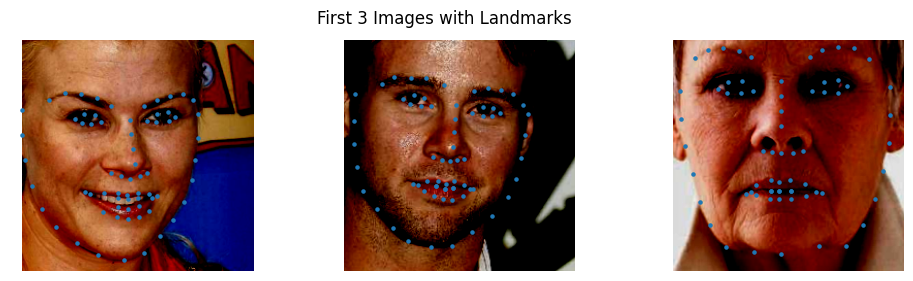

In [8]:
# Visualise 3 images as well as their corresponding facial landmarks from the test_loader

visualize_dataloader(test_loader)

<div class="alert alert-block alert-info">
    
### Task 5.2: Load and Apply Transfer Learning with Pre-trained ViT Base Model <a class="anchor" id="t5_2"></a>

Transfer learning can be employed when the goal is to use pre-trained models (ie. [ViT](https://pytorch.org/vision/stable/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16)) for a new task. The new task can be classification or numerical estimation, but the important thing about transfer learning is that you need to ensure the dataset used for the pre-training is similar in its distribution to the new task. For example, if you pre-trained model was only trained on classifcation of coloured images, it will not perform well for black and white images! 

In this task you need to:
- Load in a **vit_b_16** model **WITH** pretrained weights and print model structure of ViT
- Freeze all the parameters of the **vit_b_16** model (see PDF)
- Apply __linear probing__ by replacing the current FC layer (i.e., the **MLP Head**) in the **vit_b_16** model with a new FC layer (by default, this new FC layer will have non-frozen parameters)
    
    
<img src="figures/vit_model.png" width="700" align="center">

_Note: You will learn more about transformers the later weeks of the course. For now, we will just use ViT as a pre-trained model_

In [9]:
from torchvision.models import vit_b_16, ViT_B_16_Weights

# Load the model using torchvision and print the model structure
model = vit_b_16(pretrained=True)
print(model)

c:\Users\winky\Documents\ECE4179\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\winky\Documents\ECE4179\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [10]:
class FaceLandmarkDetection(pl.LightningModule):
    def __init__(self, learning_rate=0.001, num_classes=136):
        super().__init__()
        self.learning_rate = learning_rate 
        self.loss_fun = nn.MSELoss()  ## Define your loss! What should it be?
        
        ## Load the pre-trained network as follows
        ## vit_b_16 from models
        ## Use the importedweights of:   ViT_B_16_Weights.IMAGENET1K_V1
        ## See pytorch documentation on how to load models with a pre-trained weight
        with torch.no_grad():
            self.model = models.vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
        ## Load the pre-trained network as follows
        
        ## Freeze vit_b_16 weights (see PDF's hints)

        ## You can set the param.requires_grad = False 
        ## That way those parameters will not get updated
        for param in self.model.parameters():
            param.requires_grad = False

        ## Remake the vit_b_16 FC layer. You can use the in_features from the original model 
        self.model.heads.head = nn.Sequential(nn.Linear(self.model.hidden_dim, num_classes))

        ## Which error do we use? Remember, we are dealing with minimising coordinate errors in the landmarks
        self.val_error = MeanSquaredError()
        self.train_error = MeanSquaredError()
        self.test_error = MeanSquaredError()
            
    def forward(self, x):
        #Pass input through the model
        x_out = self.model(x)
        return x_out
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)

        landmarks = y.reshape(preds.shape[0], -1).float() ## Ensure you reshape your landmarks data to compare against the preds
        loss = self.loss_fun(preds, landmarks)
        error = self.train_error(preds, landmarks)
        
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("train_error", error, prog_bar=True, on_step=False, on_epoch=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        landmarks = y.reshape(preds.shape[0], -1)

        loss = self.loss_fun(preds, landmarks)
        error = self.val_error(preds, landmarks)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("val_error", error, prog_bar=True, on_step=False, on_epoch=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        landmarks = y.reshape(preds.shape[0], -1)
        loss = self.loss_fun(preds, landmarks)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("test_loss", loss, prog_bar=True)

    def predict_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        landmarks = y.reshape(preds.shape[0], -1)
        
        return preds,landmarks,x   ## Return 3 values here: predicted landmarks, original landmarks and the original image

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        return optimizer
    ####################
    # DATA RELATED HOOKS
    ####################

    def train_dataloader(self):
        return train_loader
    
    def val_dataloader(self):
        return valid_loader

    def test_dataloader(self):
        return test_loader

<div class="alert alert-block alert-info">
    
### Task 5.3: Train and Test the model <a class="anchor" id="t5_3"></a>

In [11]:
## Initialise your face landmark model
## Train until the end of max_epochs or if the early stopping condition has occured
## Note that if you implement it similarly to how we have done it (same hyper parameters etc.)
## Then your epoch should stop around ~110 (+/- 25 epochs)
with torch.no_grad():
    FaceLandmarkDetection_model = FaceLandmarkDetection()

# Define checkpoint callback function to save best model
checkpoint_callback = ModelCheckpoint(
        monitor="val_loss",
        dirpath="checkpoints_section_5/",
        save_top_k=1,        # save the best model
        mode="min",
        every_n_epochs=1
    )

# Create customized progress bar theme (Optional)
progress_bar_task = RichProgressBar(refresh_rate=1, leave=True,
    theme=RichProgressBarTheme(
        description="green_yellow",
        progress_bar="green1",
        progress_bar_finished="green1",
        progress_bar_pulse="#6206E0",
        batch_progress="green_yellow",
        time="grey82",
        processing_speed="grey82",
        metrics="grey82"
    )
)
# Create Early stopping callback
early_stopping = EarlyStopping('val_loss', patience = 10, mode = 'min')

# Train and test the model
trainer = pl.Trainer(
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  
    max_epochs=100,
    callbacks=[progress_bar_task, checkpoint_callback,  early_stopping],
    logger=CSVLogger(save_dir="logs_task_5/"),
)
with torch.no_grad():
    trainer.fit(FaceLandmarkDetection_model)
    trainer.test()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name        ┃ Type              ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ loss_fun    │ MSELoss           │      0 │
│ 1 │ model       │ VisionTransformer │ 85.9 M │
│ 2 │ val_error   │ MeanSquaredError  │      0 │
│ 3 │ train_error │ MeanSquaredError  │      0 │
│ 4 │ test_error  │ MeanSquaredError  │      0 │
└───┴─────────────┴───────────────────┴────────┘

Trainable params: 104 K                                                                                            
Non-trainable params: 85.8 M                                                                                       
Total params: 85.9 M                                                                                               
Total estimated model params size (MB): 343

Output()

c:\Users\winky\Documents\ECE4179\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:438
: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. 
Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in
the `DataLoader` init to improve performance.
  rank_zero_warn(

c:\Users\winky\Documents\ECE4179\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:438
: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. 
Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in
the `DataLoader` init to improve performance.
  rank_zero_warn(

c:\Users\winky\Documents\ECE4179\.venv\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:281: 
PossibleUserWarning: The number of training batches (11) is smaller than the logging interval 
Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training 
epoch.
  rank_zero_warn(

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

`Trainer.fit` stopped: `max_epochs=100` reached.


c:\Users\winky\Documents\ECE4179\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\checkpoint_connector.py:149: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at C:\Users\winky\Documents\ECE4179\ECE4179_Assignment_2023\checkpoints_section_5\epoch=99-step=1100.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at C:\Users\winky\Documents\ECE4179\ECE4179_Assignment_2023\checkpoints_section_5\epoch=99-step=1100.ckpt


Output()

c:\Users\winky\Documents\ECE4179\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:438: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     677.7301703249468     │
└───────────────────────────┴───────────────────────────┘

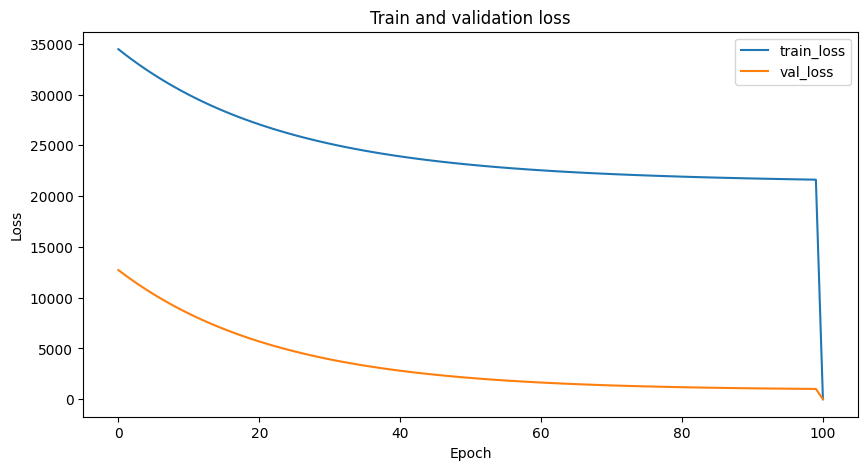

In [12]:
## Plot your train and validation losses!

# read logs , feel free to use your own code for reading logs
metrics_task = pd.read_csv(trainer.logger.log_dir + "/metrics.csv")
metrics_task.set_index("epoch", inplace=True)
metrics_task = metrics_task.groupby(level=0).sum().drop("step", axis=1)

# Plot using matplotlib
plt.figure(figsize=(10,5))
plt.plot(metrics_task["train_loss"].dropna(), label="train_loss")
plt.plot(metrics_task["val_loss"].dropna(), label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and validation loss")
plt.legend()
plt.show()

<div class="alert alert-block alert-info">
    
### Task 5.4: Visualise predicted landmarks for three of the images <a class="anchor" id="t5_4"></a>
    
Utilise the trainer predict method to output the predicted landmarks. Then overlay this with the original landmarks and the original image.

In [13]:
# Get test_loader images with original landmarks and predicted landmarks from model trained using SGD
outputs = trainer.predict(test_loader)

# Create a subplot with 1 row and 3 columns to display images


# Iterate through the first 3 samples for visualization
fig, axes = plt.subplots(1, 3, figsize=(20, 20))
            
        # preds= outputs[0][0]
        # labels = outputs[0][1]    
        # inputs= outputs[0][2]
for i in range(3):
    actual = outputs[i][1]
    pred = outputs[i][0]
    images = outputs[i][2]
    axes[i].imshow(images[i].permute(1, 2, 0))
        # Loop through the landmarks and plot them on the image
    pred_landmarks = pred[i]
    x = pred_landmarks[:,0]
    y = pred_landmarks[:,1]
    axes[i].scatter(x,y, s=5, c='r')

    original_landmarks = actual[i]
    xo = original_landmarks[:,0]
    yo = original_landmarks[:,1]
    axes[i].scatter(xo,yo, s=5, c='b')

    # Turn off the axis labels
    axes[i].axis('off')
    #axes[i].imshow(outputs[i][2])    # Display the image in the subplot
    #Legendx where blue dots are original landmarks and red dots are predicted
    axes[i].legend(['Predicted', 'Original'])
# Show the plotted images
plt.show()

TypeError: `model` must be a `LightningModule` or `torch._dynamo.OptimizedModule`, got `DataLoader`

<div class="alert alert-block alert-success">
    
### Task 5.5: Discussion Questions <a class="anchor" id="t5_5"></a>

### Questions
1. What are two things to keep in mind when choosing your pre-trained model? Why are these important? 

2. What are the differences between CNN architectures and Transformer models, such as ViT?

3. What was your thought process in finetuning your model to achieve the required test loss?
    
### Answers
    
1. First thing to keep in mind is what the pre-trained model was trained on, and if it is similar to the purpose you want to use it for. This is important because a pre-trained model could be very good at classifying the thing it was trained for, e.g image classification, but terrible at something else, like natural language processing or object detection, which could be what you need it for. Second is the capabilities of your machine, some pre-trained models require a lot of computational resources (lots of memory is needed for models with lots of parameters) which your machine may not support.
    
2. CNN use pixel arrays whereas Transformer models are applied directly to image patches for image classification tasks. Typically Transformers require fewer computational resources to train, after being pre-trained on large amounts of data. Transfomers are fantastic for Natural Language Processing, they have also been adapted for computer vision tasks, whereas CNNs are mostly used for just for image data.

3. Model took an hour to train and would take an hour for each time I change a parameter and retrain so I sadly had no time to finetune my model. One thing I could do might be to change the learning rate.


<div class="alert alert-block alert-danger">
    
## Final remarks

Well done on making it all the way to the end. We hope you have enjoyed applying deep learning concepts to further your understanding and to new applications !